In [2]:
import sys
import torch
import random
sys.path.insert(0, '..')

DATA_FILE = "../data/"
RESULT_FILE = "../result/"

random.seed(42)
torch.manual_seed(42)

## Load data

In [3]:
import os
from numpy import genfromtxt

# Load generated data
data_generated = genfromtxt(os.path.join(DATA_FILE,'generated_Millard_data.csv'), delimiter=',') # in the form [t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]
data_generated_t = data_generated[0]
GLC, ACE_env, X, ACCOA, ACP, ACE_cell = data_generated[1:]

# Load experimental data
data_1mM = genfromtxt(os.path.join(DATA_FILE,'data_1mM.csv'), delimiter=',')
data_t_1mM = data_1mM[1:, 0]   


## Choose observables and ranges for parameters

In [4]:
from lib.tools import random_ranges
from ode_equation.Millard_dicts import ode_parameters_dict, ode_parameter_ranges_dict


# Setting variables (known and unknown), parameters, parameters ranges, constants, weights 
observables = ["GLC","ACE_env","X","ACCOA","ACP","ACE_cell"]
variable_data = {v : data_generated[i+1] for i,v in enumerate(observables)}
variable_no_data  = {}
data_t=data_generated_t


# Experimetal case
# observables = ["GLC","ACE_env","X"]
# variable_data = {"GLC": data_1mM[1:, 3], "ACE_env": data_1mM[1:, 1], "X":data_1mM[1:, 2]}
# variable_no_data  = {"ACCOA":None,"ACP":None,"ACE_cell":None}
# data_t = data_t_1mM


residual_weights=[1e-4,1e-1,1e-1,1e-14,1e-15,1e-8]
parameter_names = ["v_max_AckA",
                   "v_max_Pta",
                   "v_max_glycolysis",
                   "Ki_ACE_glycolysis",
                   "Km_ACCOA_TCA_cycle",
                   "v_max_TCA_cycle",
                   "Ki_ACE_TCA_cycle",
                   "Y",
                   "v_max_acetate_exchange",
                   "Km_ACE_acetate_exchange"]

# Creating the ranges: using random_ranges or the ranges provided by Millard
ranges = random_ranges([ode_parameters_dict[key] for key in parameter_names],scale=20)
for i,name in enumerate(parameter_names):
    if name in ode_parameter_ranges_dict:
        ranges[i]= ode_parameter_ranges_dict[name]

constants_dict = ode_parameters_dict

/home/agiralt/anaconda3/envs/pinn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Neural Network training

In [5]:
import numpy as np

# Training parameters 
epoch_number = 150000

# Optimizer parameters
optimizer_type = "Adam"
optimizer_hyperparameters = {"lr":1e-4}

# Scheduler parameters
scheduler_hyperparameters = {"base_lr":1e-4, 
                             "max_lr":1e-4, 
                             "step_size_up":100,
                             "scale_mode":"exp_range",
                             "gamma":0.999,
                             "cycle_momentum":False}

# Loss calculation method
multiple_loss_method = None

multiple_loss_method = "soft_adapt"
# multiple_loss_method = None 
# multiple_loss_method = "prior_losses"
prior_loss_t = np.Infinity # initial loss
prior_loss_t = 1



In [6]:
# Create the PINN
from lib.pinn import Pinn
from ode_equation.deriv_equations_Millard import ODE_residual_dict_Millard

pinn_cell = Pinn(ode_residual_dict=ODE_residual_dict_Millard,
                 ranges=ranges,
                 data_t=data_t,
                 variables_data=variable_data,
                 variables_no_data=variable_no_data,
                 parameter_names=parameter_names,
                 optimizer_type=optimizer_type,
                 optimizer_hyperparameters=optimizer_hyperparameters,
                 scheduler_hyperparameters=scheduler_hyperparameters,
                 constants_dict=constants_dict,
                 multi_loss_method=multiple_loss_method,
                 residual_weights=residual_weights,
                 )

In [7]:
# Training
r2_score, pred_variables, losses, variable_fit_losses, residual_losses, all_learned_parameters, learning_rates = pinn_cell.train(epoch_number)
GLC_pred, ACE_env_pred, X_pred, ACCOA_pred, ACP_pred, ACE_cell_pred  = pred_variables

Training the neural network: 100%|███████████████████████████████████████████████████████████████████████████| 150000/150000 [24:02<00:00, 104.00it/s]


## Assessment

In [8]:
save_fig_choice = False
path_to_save = '../figures/'


# save_fig_choice = True
# path_to_save = './test/'

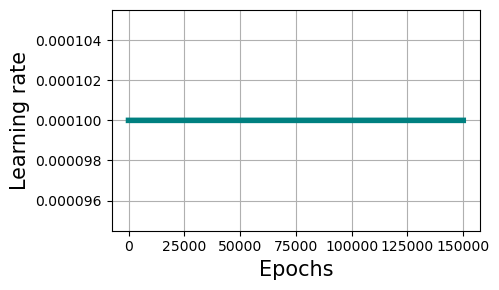

In [9]:
import matplotlib.pyplot as plt 
# Print and Plot learning rate
plt.figure(figsize=(5,3))
plt.plot(learning_rates[0:], color = 'teal',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Learning rate',fontsize=15)

plt.tight_layout()

plt.show()

Loss:  5.7119e-05


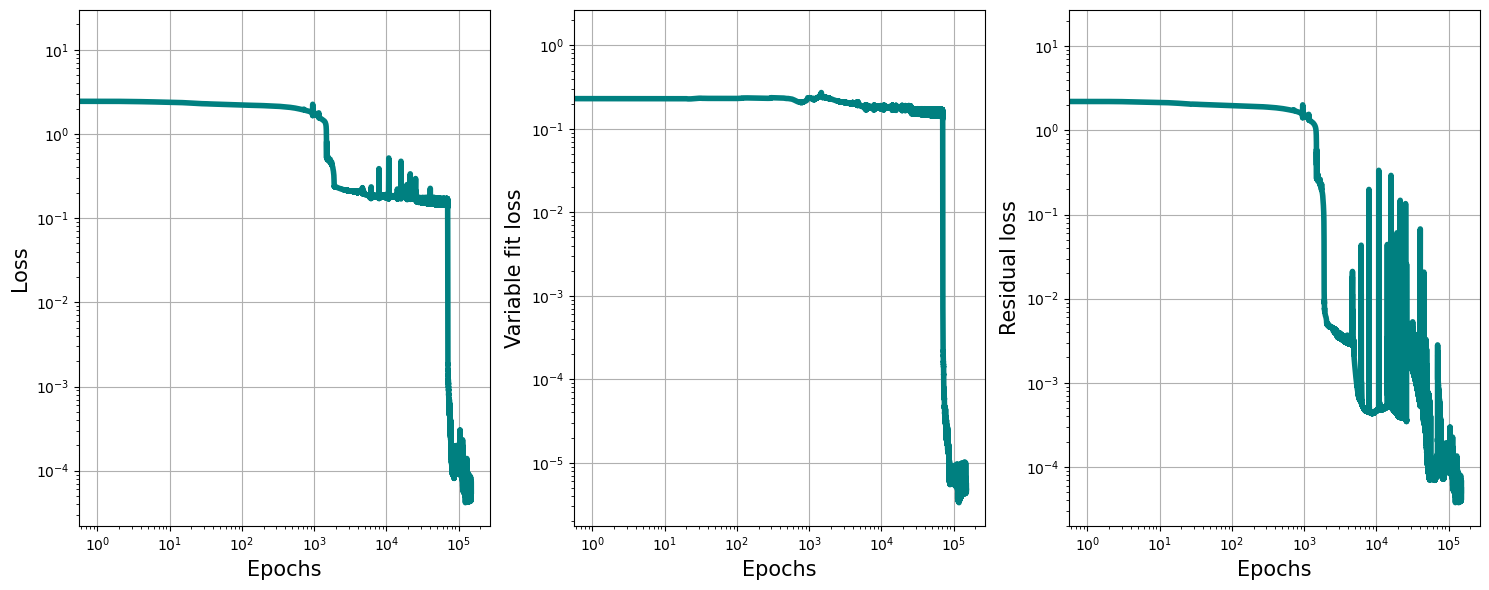

In [10]:
# Print and Plot Losses
print("Loss: ","%.5g" % losses[-1])

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].plot(losses[0:], color = 'teal',linewidth=4)
axs[0].grid(True)
axs[0].set_xlabel('Epochs',fontsize=15)
axs[0].set_ylabel('Loss',fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(variable_fit_losses[0:], color = 'teal',linewidth=4)
axs[1].grid(True)
axs[1].set_xlabel('Epochs',fontsize=15)
axs[1].set_ylabel('Variable fit loss',fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].plot(residual_losses[0:], color = 'teal',linewidth=4)
axs[2].grid(True)
axs[2].set_xlabel('Epochs',fontsize=15)
axs[2].set_ylabel('Residual loss',fontsize=15)
axs[2].set_xscale('log')
axs[2].set_yscale('log')



plt.tight_layout()

fig_name = 'loss_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

r2 : 13.814


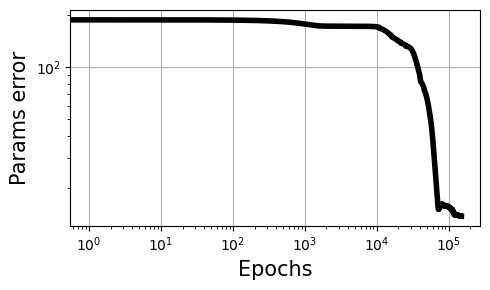

In [11]:
# Print and Plot R2 
print("r2 :","%.5g" % r2_score[-1])

plt.figure(figsize=(5,3))
plt.plot(r2_score, color = 'black',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Params error',fontsize=15)
plt.xscale('log')
plt.yscale('log')


plt.tight_layout()

fig_name = 'error_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

/tmp/ipykernel_44396/3990493709.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges


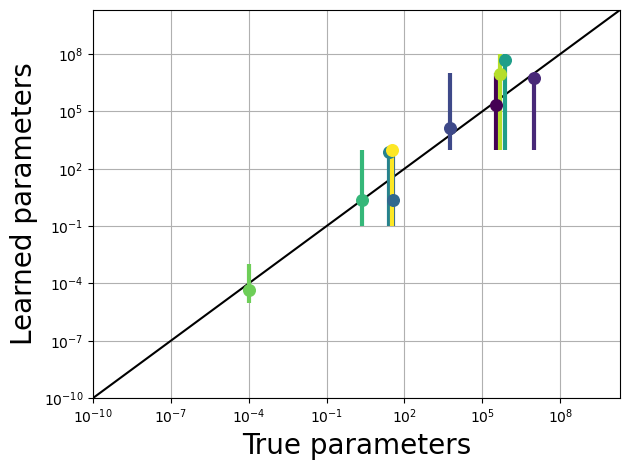

In [12]:
# Comparing parameters
learned_parameters=[pinn_cell.output_param_range(v,i).item() for (i,(k,v)) in enumerate(pinn_cell.ode_parameters.items())]
true_parameters=[ode_parameters_dict[key] for key in parameter_names]

plt.grid('true')
plt.plot([0, 2*10**10], [0, 2*10**10],color='black')
plt.scatter(true_parameters,learned_parameters)
plt.xscale('log')
plt.yscale('log')

cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges

# Map each range index to a color from the colormap
colors = [cmap(i) for i in range(len(ranges))]


for i, (true_val, learned_val) in enumerate(zip(true_parameters, learned_parameters)):
    plt.scatter(true_val, learned_val, s=70, color=colors[i], label=f'Range {i}' if i == 0 else "",zorder=3)

    # Also color the corresponding vertical line
    plt.vlines(x=true_val, ymin=ranges[i][0], ymax=ranges[i][1], colors=colors[i],zorder=2,linewidth=3)


min_value = min(r[0] for r in ranges)
max_value = max(r[1] for r in ranges)
plt.ylim([10**(-10),2*10**10])
plt.xlim([10**(-10),2*10**10])

plt.xlabel('True parameters',fontsize=20)
plt.ylabel('Learned parameters',fontsize=20)

plt.tight_layout()

fig_name = 'params_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

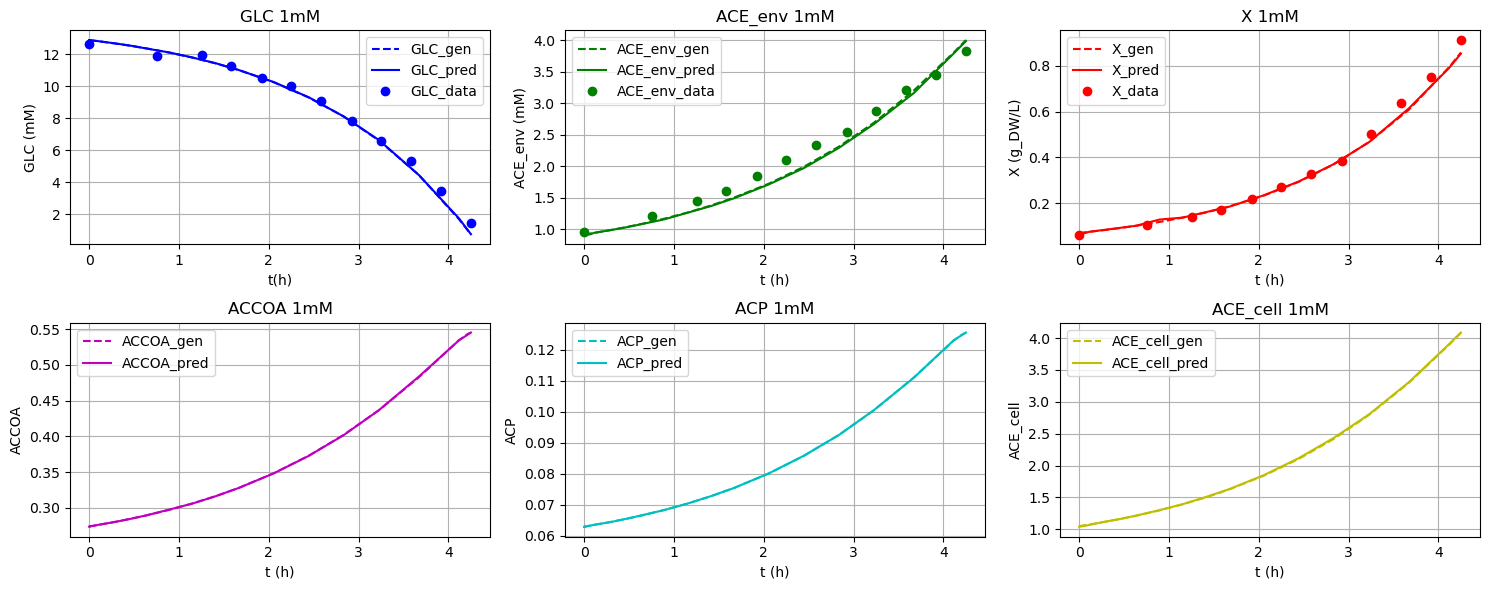

In [13]:
# Plot the predicted variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(data_generated_t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(data_t, GLC_pred.detach().numpy(), label='GLC_pred', color='b')
axs[0,0].plot(data_t_1mM, data_1mM[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t(h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(data_generated_t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(data_t, ACE_env_pred.detach().numpy(), label='ACE_env_pred', color='g')
axs[0,1].plot(data_t_1mM, data_1mM[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(data_generated_t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(data_t, X_pred.detach().numpy(), label='X_pred', color='r')
axs[0,2].plot(data_t_1mM, data_1mM[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(data_generated_t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(data_t, ACCOA_pred.detach().numpy(), label='ACCOA_pred', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(data_generated_t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(data_t, ACP_pred.detach().numpy(), label='ACP_pred', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(data_generated_t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(data_t, ACE_cell_pred.detach().numpy(), label='ACE_cell_pred', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

## Reconstruct values with learned parameters

In [14]:
from scipy.integrate import solve_ivp
from ode_equation.deriv_equations_Millard import deriv_Millard


# Integrate the Millard's model equations over the time grid
learned = ode_parameters_dict.copy()
learned = learned | dict(zip(parameter_names, learned_parameters))

# initial conditions
y_1_0 = [d[0] for d in data_generated[1:]]

net_res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(learned,),
                # args=(new_ode_parameters,),
                t_eval=data_t,
                dense_output=True)

GLC_learned, ACE_env_learned, X_learned, ACCOA_learned, ACP_learned, ACE_cell_learned = net_res.y

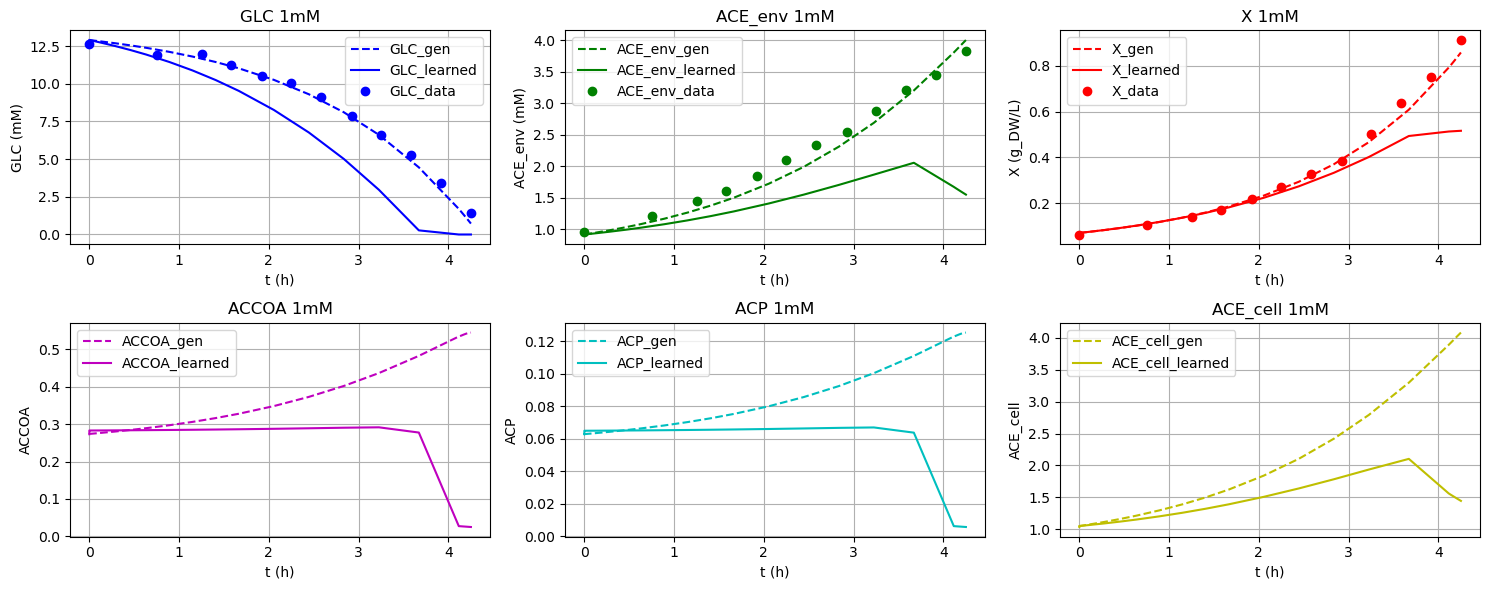

In [15]:
from lib.tools import ssr_error
from ode_equation.Millard_dicts import variable_standard_deviations_dict


# Plot the solved variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(data_generated_t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(net_res.t, GLC_learned, label='GLC_learned', color='b')
axs[0,0].plot(data_1mM[1:, 0], data_1mM[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(data_generated_t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(net_res.t, ACE_env_learned, label='ACE_env_learned', color='g')
axs[0,1].plot(data_1mM[1:, 0], data_1mM[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(data_generated_t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(net_res.t, X_learned,label='X_learned', color='r')
axs[0,2].plot(data_1mM[1:, 0], data_1mM[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(data_generated_t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(net_res.t, ACCOA_learned, label='ACCOA_learned', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(data_generated_t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(net_res.t, ACP_learned, label='ACP_learned', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(data_generated_t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(net_res.t, ACE_cell_learned, label='ACE_cell_learned', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()


In [16]:
variable_res = {"GLC":GLC_learned, 
                "ACE_env":ACE_env_learned, 
                "X":X_learned, 
                "ACCOA":ACCOA_learned, 
                "ACP":ACP_learned, 
                "ACE_cell":ACE_cell_learned}
error = ssr_error(standard_deviations_dict=variable_standard_deviations_dict, observables=observables, variable_data=variable_data, variable_res=variable_res)
print("Sum of squared residuals error: " + str(error))

Sum of squared residuals error: 1458.5908022341378


In [17]:
# Print and compare parameters
from lib.tools import param_error_percentages

print("Learned parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", learned_parameters[i])

print("\nTrue parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", true_parameters[i])

print("\nParameters errors :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", param_error_percentages(true_parameters,learned_parameters)[i])



Learned parameters :
v_max_AckA : 214061.71875
v_max_Pta : 5645813.5
v_max_glycolysis : 14206.7705078125
Ki_ACE_glycolysis : 2.39392352104187
Km_ACCOA_TCA_cycle : 710.3675537109375
v_max_TCA_cycle : 46273732.0
Ki_ACE_TCA_cycle : 2.3063433170318604
Y : 4.528017598204315e-05
v_max_acetate_exchange : 8679347.0
Km_ACE_acetate_exchange : 964.5297241210938

True parameters :
v_max_AckA : 336940.01763224584
v_max_Pta : 9565521.763455136
v_max_glycolysis : 5557.64
Ki_ACE_glycolysis : 36.6776
Km_ACCOA_TCA_cycle : 24.759179607035055
v_max_TCA_cycle : 740859.8734990103
Ki_ACE_TCA_cycle : 2.3261654310710522
Y : 9.980425734506176e-05
v_max_acetate_exchange : 480034.5536336427
Km_ACE_acetate_exchange : 33.15358053265956

Parameters errors :
v_max_AckA : 0.3646889429927012
v_max_Pta : 0.40977464276233155
v_max_glycolysis : 1.5562595828107795
Ki_ACE_glycolysis : 0.9347306388356417
Km_ACCOA_TCA_cycle : 27.691078015730948
v_max_TCA_cycle : 61.459492888248334
Ki_ACE_TCA_cycle : 0.008521369019771324
Y : 0

## Saving results

In [17]:
import pandas as pd
import csv

hyperparameters = {
    "epochs":epoch_number,
    "optimizer":str(optimizer_type),
    "optimizer_hyperparameters":str(optimizer_hyperparameters),
    "scheduler":str(scheduler_hyperparameters),
    "multiple_loss_method":multiple_loss_method,
    "ssr_error":error,
    "parameter_names": str(parameter_names),
    "soft_adapt_beta":pinn_cell.soft_adapt_beta,
    "soft_adapt_t":pinn_cell.soft_adapt_t,
    "residual_weights":str(pinn_cell.residual_weights),
    "variable_fit_weights":str(pinn_cell.variable_fit_weights),
    "prior_losses_t":pinn_cell.prior_losses_t,
}

# Saving results
fieldnames = ["epochs",
              "optimizer",
              "optimizer_hyperparameters",
              "scheduler",
              "multiple_loss_method",
              "ssr_error",
              "parameter_names",
              "soft_adapt_beta",
              "soft_adapt_t",
              "residual_weights",
              "variable_fit_weights",
              "prior_losses_t",]

with open(os.path.join(RESULT_FILE,'raw_toy_results_data.csv'), mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow(hyperparameters)